In [1]:
DATASET_BASE_PATH = '../Datasets'
DATASET_PATH = DATASET_BASE_PATH + '/Numbers'
TRAINED_MODELS_PATH = '../TrainedModels'
MODEL_SAVE_PATH = TRAINED_MODELS_PATH + '/numbers_model_100x100.keras'


In [2]:
#Traemos el dataset desde la pagina de github

# if folder ./Datasets/Numbers don't exists download and unzip the dataset
import os.path
if not os.path.exists(DATASET_PATH):
    !gdown https://drive.google.com/uc?id=1pwt_IW5hC_ohA9Q2QO5zE_rkusuEHYgD -O dt.zip
    command = 'unzip dt.zip -d ' + DATASET_BASE_PATH
    !{command}
    !rm dt.zip


In [ ]:
#tensorrt is a bit special to install and we didn't add it to pipenv
!pip install tensorrt==8.5.3.1

In [4]:
#importamos todas las librerias a usar
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

from tensorflow.keras                       import regularizers
from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.callbacks             import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers            import SGD

import matplotlib.pyplot as plt

2.14.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
#parametros configurables
bs = 32 #bach size
image_side = 100 #image is an square 56x56
epochs = 25

In [7]:
##Cargamos imagenes de la carpeta en un dataset
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH+"/Train",
  label_mode = "categorical",
  seed=123,
  image_size=(image_side, image_side),
  batch_size=bs)

raw_validation_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH+"/Test",
  label_mode = "categorical",
  seed=123,
  image_size=(image_side, image_side),
  batch_size=bs)

Found 8809 files belonging to 10 classes.
Found 2062 files belonging to 10 classes.


In [8]:
#definimos clases
class_names = raw_train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [9]:
#normalizamos dataset de escala 0,255 a 0,1
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = raw_validation_ds.map(lambda x, y: (normalization_layer(x), y))

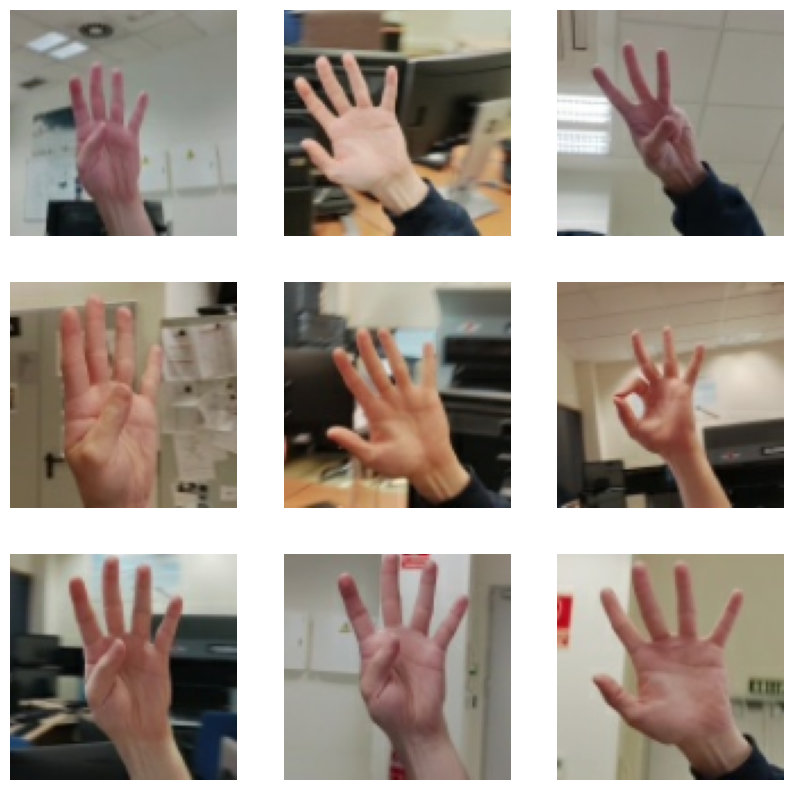

In [10]:
#Mostramos imagen de entrenamiento normalizada sin modificaciones
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #images contiene un batch(32) de imagenes de 56x56x3
  #labels contiene un array de 32 arrays con 10 clases marcando un 1 o 0 dependiendo de la clase de cada imagen
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()) ## usar .astype("uint8") si las imagenes van de 0 a 255 si no float 0 a 1
    #plt.title(class_names[labels[i].numpy().tolist().index(1)-2])
    plt.axis("off")

In [11]:
#Configuramos nuestra capa de data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        #tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomBrightness((-0.3,0.3),value_range=(0,1)),
        tf.keras.layers.RandomTranslation(0.05, 0.2),
        #tf.keras.layers.RandomCrop(25,25),
        #tf.keras.layers.RandomContrast(0.3)
    ]
)
data_augmentation.build((None, image_side, image_side, 3)) ## this is important to prevent usage of data augmentation change his shape

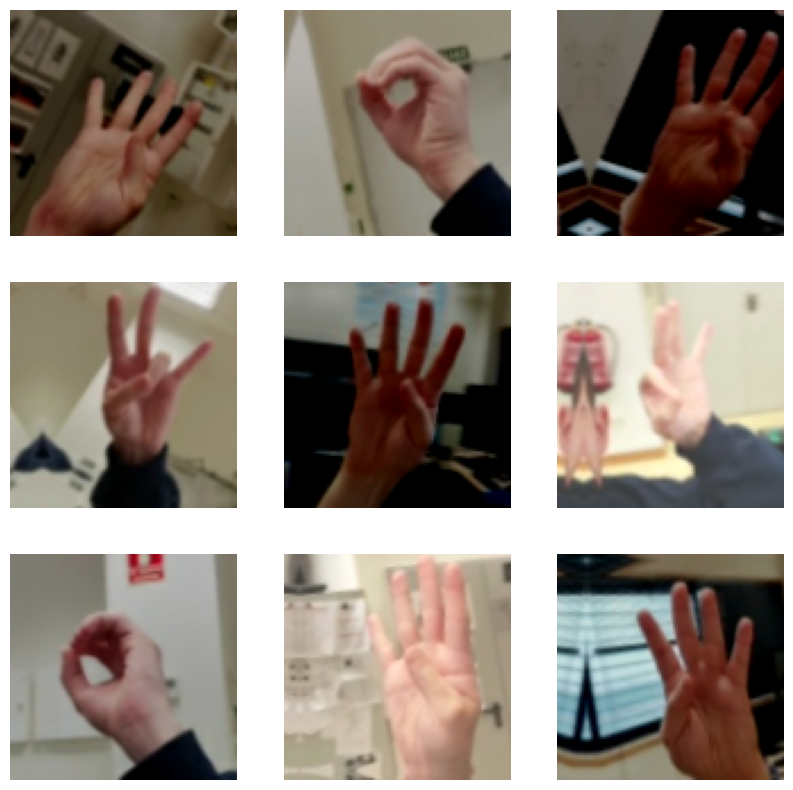

In [11]:
#probamos nuestro data augmentation
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #images contiene un batch(32) de imagenes de 56x56x3
  #labels contiene un array de 32 arrays con 10 clases marcando un 1 o 0 dependiendo de la clase de cada imagen
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(images[i].numpy())) ## usar .astype("uint8") si las imagenes van de 0 a 255 si no float 0 a 1
    #plt.title(class_names[labels[i].numpy().tolist().index(1)-2])
    plt.axis("off")

In [12]:
# VGG19
# Importamos el modelo base que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(image_side, image_side, 3),
                                          include_top=False,
                                          weights='imagenet')

#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[1:6]:
  layer.trainable = False

##DEFINIMOS EL MODELO



# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Data augmentation
model.add(data_augmentation)
data_augmentation.summary()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)
VGG19_model.summary()




# Continuamos añadiendo más capas que sí serán entrenadas...
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_names), activation = 'softmax'))

model.build((None, image_side, image_side, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 100, 100, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 100, 100, 3)       0         
 ation)                                                          
                                                                 
 random_brightness (RandomB  (None, 100, 100, 3)       0         
 rightness)                                                      
                                                                 
 random_translation (Random  (None, 100, 100, 3)       0         
 Translation)                                                    
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
__________________________

In [13]:
## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy",
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback para guardar checkpoints y modificar el learning rate dinamicamente
#checkpointer = ModelCheckpoint(filepath='model', verbose=1, save_best_only=True,
#                               monitor = 'val_accuracy', mode = 'max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=3, min_lr=0.000001)

history = model.fit(train_ds,validation_data = validation_ds,
                             callbacks = [
#                                 reduce_lr,
#                                 checkpointer
                                ],
                   epochs=epochs)

Epoch 1/25


2023-12-24 11:25:55.627625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906
2023-12-24 11:25:56.556866: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fedcc9b5f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-24 11:25:56.556904: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-24 11:25:56.610704: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


276/276 [==============================] - 12s 31ms/step - loss: 2.8201 - accuracy: 0.4710 - val_loss: 5.3075 - val_accuracy: 0.1697
Epoch 2/25
276/276 [==============================] - 8s 30ms/step - loss: 2.0314 - accuracy: 0.7348 - val_loss: 4.2371 - val_accuracy: 0.2347
Epoch 3/25
276/276 [==============================] - 8s 30ms/step - loss: 1.6717 - accuracy: 0.8482 - val_loss: 3.9169 - val_accuracy: 0.3419
Epoch 4/25
276/276 [==============================] - 8s 29ms/step - loss: 1.5006 - accuracy: 0.9038 - val_loss: 4.0070 - val_accuracy: 0.3404
Epoch 5/25
276/276 [==============================] - 8s 30ms/step - loss: 1.3822 - accuracy: 0.9411 - val_loss: 3.5078 - val_accuracy: 0.3860
Epoch 6/25
276/276 [==============================] - 8s 29ms/step - loss: 1.3345 - accuracy: 0.9541 - val_loss: 3.2320 - val_accuracy: 0.4035
Epoch 7/25
276/276 [==============================] - 8s 29ms/step - loss: 1.2796 - accuracy: 0.9671 - val_loss: 3.1056 - val_accuracy: 0.4462
Epoch 8/2

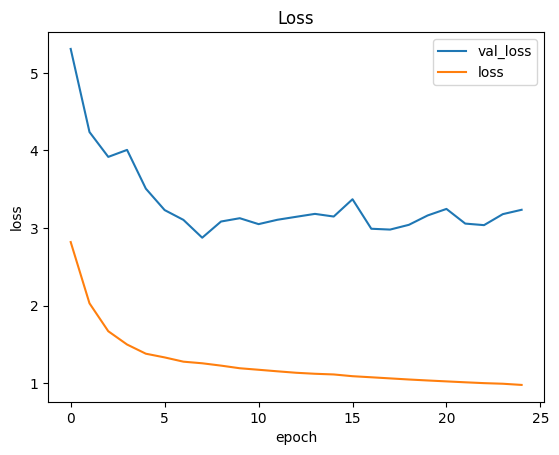

In [14]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['val_loss','loss'])
plt.show()

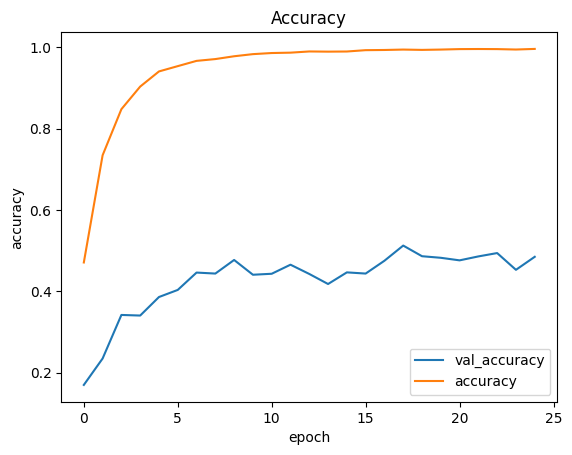

In [15]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['val_accuracy','accuracy'])
plt.show()

In [ ]:
model.save(MODEL_SAVE_PATH)

In [28]:
## load model from zero
model = tf.keras.models.load_model("../TrainedModels/numbers_model_100x100_70pc.keras")

In [16]:
model.evaluate(validation_ds)

65/65 [==============================] - 1s 13ms/step - loss: 3.2357 - accuracy: 0.4850


[3.2356913089752197, 0.4849660396575928]

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("normalized")
  else:
    print("without normalization")

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() /2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, format(cm[i,j],fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

import numpy as np

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
print(predicted_labels)



1/1 [==============================] - 0s 94ms/step
tf.Tensor([5 3 3 ... 7 0 2], shape=(2062,), dtype=int64)


In [18]:
final_correct_labels = []
for lb in correct_labels:
  itlist=list(lb.numpy())
  final_correct_labels.append(itlist.index(1.0))

In [19]:

cm = confusion_matrix(predicted_labels, final_correct_labels)

without normalization
[[201  13   0   0   0   0   0   0   1   0]
 [  0  62   2   0   0   0   0   0   1   1]
 [  1  61  37   2   0   0   0   5  11   5]
 [  1  62 117 173   1   0   1  30  70   7]
 [  0   1   1   0 157  15  68  16  13  68]
 [  1   4   4  22  36 192  40  18   9  75]
 [  0   0  31   6  12   0  90  60  38  36]
 [  0   2  13   3   1   0   8  77  65   1]
 [  0   0   0   0   0   0   0   0   0   0]
 [  1   1   1   0   0   0   0   0   0  11]]


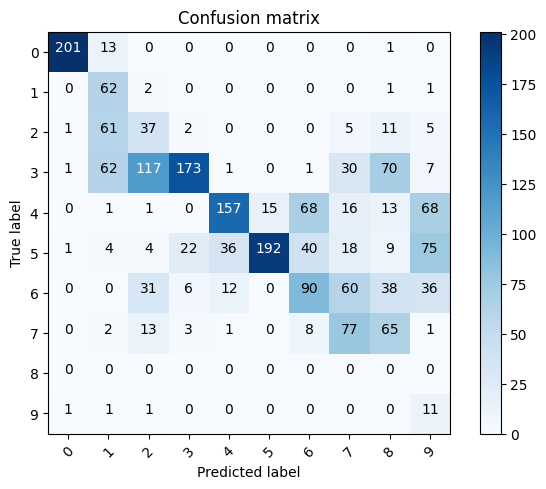

In [20]:
plot_confusion_matrix(cm,class_names)